## UNet Architecture for PyTorch

## By Farzam

### Carvana Dataset

In [1]:
!nvidia-smi

Fri Jul 21 16:53:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:81:00.0 Off |                    0 |
| N/A   38C    P0              73W / 400W |   4064MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Package Imports

In [2]:
import numpy as np
import pandas as pd
import os

import glob
import zipfile
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, CenterCrop
from torchvision import transforms as T, datasets as dset


torch.manual_seed(42)

In [3]:
input_dir = "./../carvana/"

## Getting the Images and Masks

In [4]:
train_val_images_path = os.path.join(input_dir, 'train')

train_val_images = os.listdir(train_val_images_path)

train_val_images = sorted(train_val_images)

train_val_images = [s.split("/")[-1].split(".")[0] for s in train_val_images]

len(train_val_images)

5088

### Splitting the data into train and validation

In [5]:
train_images, val_images = train_test_split(train_val_images, test_size=0.2)

### Sampling of file paths

In [6]:
train_images[0], val_images[0]

('6e016b8b3617_07', '68fcee2be01f_15')

In [7]:
len(train_images), len(val_images)

(4070, 1018)

In [8]:
# Default Carvana dataset images have high shapes.
# We manage to resize them.
img_size = 576

# Creating a Dataset, which inherits from the Dataset class of Torch.
class CustomImageDataset(Dataset):
    def __init__(self, img_ids, transform=None):
        self.img_ids = img_ids
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        
        # Accesing the files (images, masks)
        img_path = os.path.join(input_dir, "train/" + img_id + ".jpg")
        mask_path = os.path.join(input_dir, "train_masks/" + img_id + "_mask.gif")
        
        image = Image.open(img_path)
        image = image.resize((img_size, img_size))
        mask = Image.open(mask_path).convert("L")
        mask = mask.resize((img_size, img_size))
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

### Creating custom Datasets for Train and Validation

In [9]:
training_data = CustomImageDataset(train_images, ToTensor())
val_data = CustomImageDataset(val_images, ToTensor())

In [10]:
sample_x, sample_y = training_data[0]

print(f'Sample X Shape: {sample_x.shape}')
print(f'Sample y Shape: {sample_y.shape}')

Sample X Shape: torch.Size([3, 576, 576])
Sample y Shape: torch.Size([1, 576, 576])


### Creating DataLoaders for train and validation data

In [11]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=True)

### Setting up the `GPU` or `CPU` environment

In [12]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [13]:
# To implement the UNet module, we need convolutional blocks for up/downsampling.
# These convolutional blocks help us to have specific number of nodes for every single needed layer.
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            
            # NOTE: Testing BatchNormalization for next versions!
            # Not realiable at the moment.
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x: torch.Tensor):
        return self.block(x)

# To implement the bottle neck, we implement the SkipConnection class.
class SkipConnection(nn.Module):
    def forward(self, x: torch.Tensor, encoded: torch.Tensor):
        _, _, h, w = encoded.shape
        crop = T.CenterCrop((h, w))(x)
        output = torch.cat((x, crop), 1)
        
        return output


# Constructing the UNet architecture using the above implemented classes.
class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(UNet, self).__init__()
        
        self.encoders = nn.ModuleList([
            ConvBlock(in_channels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
        ])
        self.down_sample = nn.MaxPool2d(2)
        self.skipconnection = SkipConnection()
        self.decoders = nn.ModuleList([
            ConvBlock(1024, 512),
            ConvBlock(512, 256),
            ConvBlock(256, 128),
            ConvBlock(128, 64),
        ])
        
        # PixelShuffle, UpSample will modify the output channel (you can add extra operation to update the channel, e.g.conv2d)
        self.up_samples = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        ])

        
        self.bottleneck = ConvBlock(512, 1024)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1, stride=1)
        
    def forward(self, x: torch.Tensor):
        # encod
        encoded_features = []
        for enc in self.encoders:
            x = enc(x)
            encoded_features.append(x)
            x = self.down_sample(x)
            
        
        x = self.bottleneck(x)
        
        # decode
        for idx, denc in enumerate(self.decoders):
            x = self.up_samples[idx](x)
            encoded = encoded_features.pop()
            x = self.skipconnection(x, encoded)
            x = denc(x)
            
        output = self.final_conv(x)
        return output

### Creating the UNet model using ConvEncoders and SkipConnection

In [14]:
model = UNet(in_channels=3, out_channels=1).to(device)
print(model)

UNet(
  (encoders): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      

### Defining the loss function and the Optimizer

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

### Training the model over the dataLoaders

In [16]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    # Creating the train_loss variable to access the train loss over each iteration.
    train_losses = []
    
    for batch, (X, y) in enumerate(dataloader):
        # Converting our X (images), y (masks) to the format that gpu can use.
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        
        train_losses.append(loss.item())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return train_losses

In [17]:
epochs = 3

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    history = train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.672045  [   16/ 4070]
loss: 0.136064  [ 1616/ 4070]
loss: 0.091499  [ 3216/ 4070]
Epoch 2
-------------------------------
loss: 0.073076  [   16/ 4070]
loss: 0.055523  [ 1616/ 4070]
loss: 0.045917  [ 3216/ 4070]
Epoch 3
-------------------------------
loss: 0.037070  [   16/ 4070]
loss: 0.030010  [ 1616/ 4070]
loss: 0.025499  [ 3216/ 4070]
Done!


In [18]:
def plot_images(images, mask = False):
    fig = plt.figure(figsize=(10, 8))
    columns = len(images)
    rows = 1
    for i in range(columns * rows):
        img = images[i]
        fig.add_subplot(rows, columns, i + 1)
        if mask:
            img = img > 0.5
        plt.imshow(img, cmap="gray")
    plt.show()

In [19]:
def visualize_result(dataloader):
    tr_imgs = []
    msk_imgs = []
    
    for x, y in dataloader:
        x = x.to(device)
        
        pred = model(x)
        
        for i in range(x.shape[0]):
            tr_img = x[i].cpu().detach().numpy()
            tr_img = np.einsum('kij->ijk',tr_img)
            tr_imgs.append(tr_img)
            
            msk_img = pred[i].cpu().detach().numpy()
            msk_img = msk_img.reshape((img_size, img_size))
            msk_imgs.append(msk_img)

        break
        
    plot_images(tr_imgs, mask=False)
    plot_images(msk_imgs, mask=True)

In [20]:
def plot_history(losses):
    plt.style.use('ggplot')
    plt.plot(losses)
    plt.title('Train loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

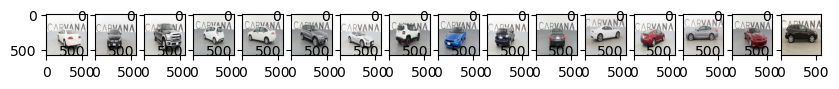

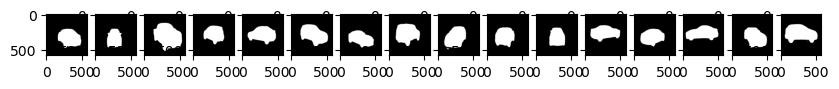

In [21]:
visualize_result(val_dataloader)

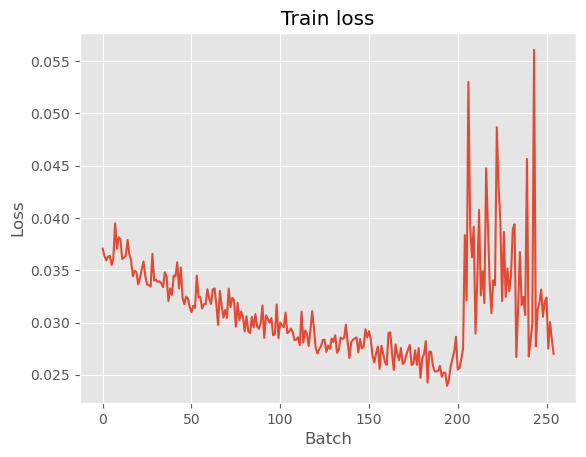

In [22]:
plot_history(history)

In [23]:
torch.save(model.state_dict(), "model.pth")